# shap-class用データ準備

このNotebookは、`data/features/latest/wikiart_vlm_features_with_gestalt_Stable-Diffusion.csv`を読み込み、`shap_class_rf_ipynb_work.py`で使用できる形式に変換します。

## 処理内容

1. データの読み込み
2. 特徴量カラムの抽出（label以外の数値カラム、説明文カラムを除外）
3. データの確認（ラベル分布、特徴量数など）
4. train/validation分割（70/30、stratifyを使用してラベル分布を同数に保持）
5. CSVファイルとして保存
6. 保存されたデータの確認

## 出力

- `shap_class_rf/dataset/train_num.csv` (70%)
- `shap_class_rf/dataset/validation_num.csv` (30%)


In [17]:
# ライブラリのインポート
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import os

# プロジェクトルートを取得
# 現在の作業ディレクトリから、プロジェクトルートを探す
current_dir = Path.cwd()
# notebooks/ディレクトリがある場合、その親がプロジェクトルート
if (current_dir / "notebooks").exists():
    project_root = current_dir
elif current_dir.name == "notebooks":
    project_root = current_dir.parent
else:
    # プロジェクトルートを探す（config.yamlやREADME.mdがあるディレクトリ）
    project_root = current_dir
    while project_root != project_root.parent:
        if (project_root / "config.yaml").exists() or (project_root / "README.md").exists():
            break
        project_root = project_root.parent

# 作業ディレクトリをプロジェクトルートに設定
os.chdir(project_root)
print(f"プロジェクトルート: {project_root}")
print(f"現在の作業ディレクトリ: {os.getcwd()}")

# 日本語フォントの設定（必要に応じて）
# plt.rcParams['font.family'] = 'DejaVu Sans'

print("ライブラリのインポート完了")


プロジェクトルート: /Users/toshiohanawa/Documents/projects/sophia/explainable-art-classification
現在の作業ディレクトリ: /Users/toshiohanawa/Documents/projects/sophia/explainable-art-classification
ライブラリのインポート完了


## 1. データの読み込み


データファイルを読み込み中: /Users/toshiohanawa/Documents/projects/sophia/explainable-art-classification/data/features/latest/wikiart_vlm_features_with_gestalt_Stable-Diffusion.csv

データの基本情報:
  行数: 17,328
  列数: 56
  メモリ使用量: 33.63 MB

ラベル分布:
label
0    8664
1    8664
Name: count, dtype: int64
  ラベル0 (本物): 8,664件 (50.0%)
  ラベル1 (フェイク): 8,664件 (50.0%)


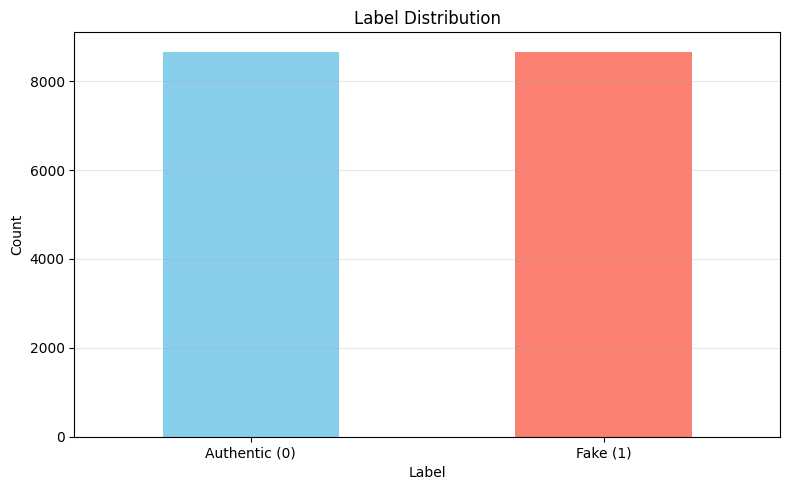

In [18]:
# データファイルのパス（プロジェクトルート基準）
input_file = project_root / "data/features/latest/wikiart_vlm_features_with_gestalt_Stable-Diffusion.csv"

# ファイルの存在確認
if not input_file.exists():
    raise FileNotFoundError(f"データファイルが見つかりません: {input_file}\n現在の作業ディレクトリ: {os.getcwd()}")

# データの読み込み
print(f"データファイルを読み込み中: {input_file}")
df = pd.read_csv(input_file)

# データの基本情報を表示
print(f"\nデータの基本情報:")
print(f"  行数: {len(df):,}")
print(f"  列数: {len(df.columns)}")
print(f"  メモリ使用量: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# ラベル分布を確認
print(f"\nラベル分布:")
label_counts = df['label'].value_counts().sort_index()
print(label_counts)
print(f"  ラベル0 (本物): {label_counts.get(0, 0):,}件 ({label_counts.get(0, 0)/len(df)*100:.1f}%)")
print(f"  ラベル1 (フェイク): {label_counts.get(1, 0):,}件 ({label_counts.get(1, 0)/len(df)*100:.1f}%)")

# ラベル分布の可視化
plt.figure(figsize=(8, 5))
label_counts.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Label Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks([0, 1], ['Authentic (0)', 'Fake (1)'], rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


## 2. 特徴量カラムの抽出


In [19]:
# 除外するカラムを定義
exclude_columns = [
    'label',  # 目的変数（後で追加）
    'image_id', 'image_path', 'source', 'generation_model', 'image_name',  # メタデータ
]

# 説明文カラムを除外（*_explanationで終わるカラム）
explanation_columns = [col for col in df.columns if col.endswith('_explanation')]
exclude_columns.extend(explanation_columns)

print(f"除外するカラム数: {len(exclude_columns)}")
print(f"除外カラム: {exclude_columns[:10]}...")  # 最初の10個を表示

# 特徴量カラムを抽出（数値カラムのみ、除外カラムを除く）
feature_columns = [col for col in df.columns 
                   if col not in exclude_columns 
                   and pd.api.types.is_numeric_dtype(df[col])]

print(f"\n特徴量カラム数: {len(feature_columns)}")
print(f"特徴量カラム（最初の10個）: {feature_columns[:10]}")

# 特徴量の基本統計量を表示
print(f"\n特徴量の基本統計量:")
print(df[feature_columns].describe().T.head(10))


除外するカラム数: 12
除外カラム: ['label', 'image_id', 'image_path', 'source', 'generation_model', 'image_name', 'simplicity_explanation', 'proximity_explanation', 'similarity_explanation', 'continuity_explanation']...

特徴量カラム数: 44
特徴量カラム（最初の10個）: ['mean_hue', 'mean_saturation', 'mean_value', 'hue_std', 'saturation_std', 'value_std', 'color_diversity', 'dominant_color_hue_mean', 'dominant_color_hue_std', 'dominant_color_saturation_mean']

特徴量の基本統計量:
                                  count         mean          std        min  \
mean_hue                        17328.0    52.672793    21.709150   0.000000   
mean_saturation                 17328.0    91.534395    34.240930   0.000000   
mean_value                      17328.0   146.447143    29.812544  23.706249   
hue_std                         17328.0    34.277895    13.469574   0.000000   
saturation_std                  17328.0    51.422770    15.234957   0.000000   
value_std                       17328.0    56.532640    12.811071   8.550111   

## 3. データの確認


In [20]:
# 特徴量とlabelのみを含むデータフレームを作成
data_for_shap = df[feature_columns + ['label']].copy()

print(f"shap-class用データ:")
print(f"  行数: {len(data_for_shap):,}")
print(f"  列数: {len(data_for_shap.columns)}")
print(f"  特徴量数: {len(feature_columns)}")
print(f"  目的変数: label")

# 欠損値の確認
missing_values = data_for_shap.isnull().sum()
if missing_values.sum() > 0:
    print(f"\n欠損値:")
    print(missing_values[missing_values > 0])
else:
    print(f"\n欠損値: なし")

# データ型の確認
print(f"\nデータ型:")
print(data_for_shap.dtypes.value_counts())


shap-class用データ:
  行数: 17,328
  列数: 45
  特徴量数: 44
  目的変数: label

欠損値: なし

データ型:
float64    38
int64       7
Name: count, dtype: int64


## 4. train/validation分割（70/30、stratifyを使用）


データ分割結果:
  Train: 12,129件 (70.0%)
  Validation: 5,199件 (30.0%)

Train setのラベル分布:
label
0    6064
1    6065
Name: count, dtype: int64
  ラベル0 (本物): 6,064件 (50.0%)
  ラベル1 (フェイク): 6,065件 (50.0%)

Validation setのラベル分布:
label
0    2600
1    2599
Name: count, dtype: int64
  ラベル0 (本物): 2,600件 (50.0%)
  ラベル1 (フェイク): 2,599件 (50.0%)


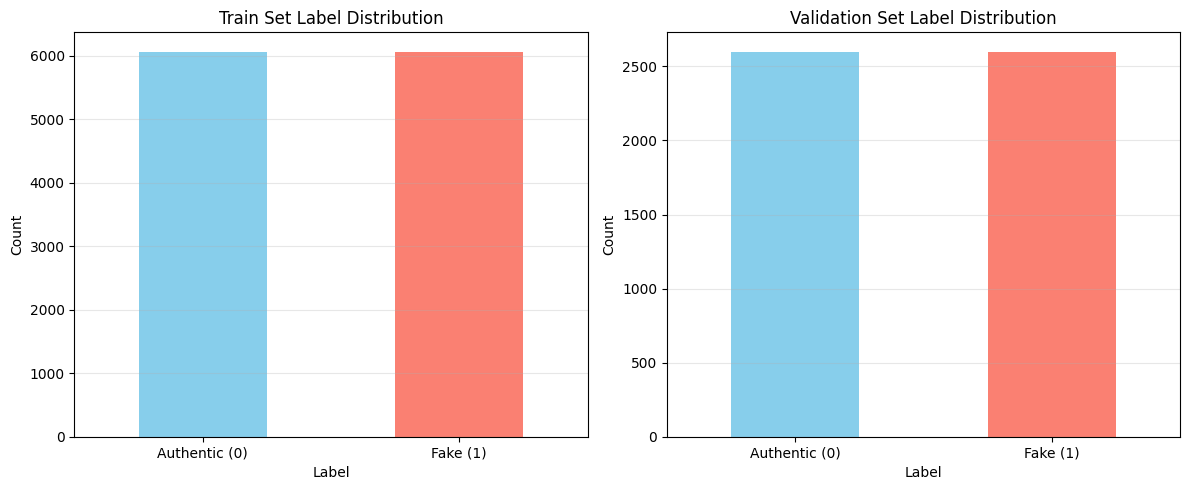


ラベル分布の比率:
  Train: 1.000 (1.0に近いほど同数)
  Validation: 1.000 (1.0に近いほど同数)


In [21]:
# train/validation分割（70/30）
# stratifyを使用してラベル分布を同数に保持
# 元のデータが50/50の場合、train/validationでも各クラスが同数（50/50）になる
train_df, val_df = train_test_split(
    data_for_shap,
    test_size=0.3,
    random_state=42,
    stratify=data_for_shap['label']  # ラベル分布を保持（各セットで50/50になる）
)

print(f"データ分割結果:")
print(f"  Train: {len(train_df):,}件 ({len(train_df)/len(data_for_shap)*100:.1f}%)")
print(f"  Validation: {len(val_df):,}件 ({len(val_df)/len(data_for_shap)*100:.1f}%)")

# 分割後のラベル分布を確認
print(f"\nTrain setのラベル分布:")
train_label_counts = train_df['label'].value_counts().sort_index()
print(train_label_counts)
print(f"  ラベル0 (本物): {train_label_counts.get(0, 0):,}件 ({train_label_counts.get(0, 0)/len(train_df)*100:.1f}%)")
print(f"  ラベル1 (フェイク): {train_label_counts.get(1, 0):,}件 ({train_label_counts.get(1, 0)/len(train_df)*100:.1f}%)")

print(f"\nValidation setのラベル分布:")
val_label_counts = val_df['label'].value_counts().sort_index()
print(val_label_counts)
print(f"  ラベル0 (本物): {val_label_counts.get(0, 0):,}件 ({val_label_counts.get(0, 0)/len(val_df)*100:.1f}%)")
print(f"  ラベル1 (フェイク): {val_label_counts.get(1, 0):,}件 ({val_label_counts.get(1, 0)/len(val_df)*100:.1f}%)")

# ラベル分布の可視化
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Train set
train_label_counts.plot(kind='bar', ax=axes[0], color=['skyblue', 'salmon'])
axes[0].set_title('Train Set Label Distribution')
axes[0].set_xlabel('Label')
axes[0].set_ylabel('Count')
axes[0].set_xticklabels(['Authentic (0)', 'Fake (1)'], rotation=0)
axes[0].grid(axis='y', alpha=0.3)

# Validation set
val_label_counts.plot(kind='bar', ax=axes[1], color=['skyblue', 'salmon'])
axes[1].set_title('Validation Set Label Distribution')
axes[1].set_xlabel('Label')
axes[1].set_ylabel('Count')
axes[1].set_xticklabels(['Authentic (0)', 'Fake (1)'], rotation=0)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# ラベル分布が同数であることを確認
train_ratio = train_label_counts.get(0, 0) / train_label_counts.get(1, 0) if train_label_counts.get(1, 0) > 0 else 0
val_ratio = val_label_counts.get(0, 0) / val_label_counts.get(1, 0) if val_label_counts.get(1, 0) > 0 else 0
print(f"\nラベル分布の比率:")
print(f"  Train: {train_ratio:.3f} (1.0に近いほど同数)")
print(f"  Validation: {val_ratio:.3f} (1.0に近いほど同数)")


## 5. データの保存


In [22]:
# 出力ディレクトリの作成（プロジェクトルート基準）
output_dir = project_root / "shap_class_rf/dataset"
output_dir.mkdir(parents=True, exist_ok=True)

print(f"出力ディレクトリ: {output_dir}")

# CSVファイルとして保存
train_file = output_dir / "train_num.csv"
val_file = output_dir / "validation_num.csv"

train_df.to_csv(train_file, index=False)
val_df.to_csv(val_file, index=False)

print(f"\nデータを保存しました:")
print(f"  Train: {train_file}")
print(f"    - 行数: {len(train_df):,}")
print(f"    - 列数: {len(train_df.columns)}")
print(f"    - ファイルサイズ: {train_file.stat().st_size / 1024**2:.2f} MB")

print(f"\n  Validation: {val_file}")
print(f"    - 行数: {len(val_df):,}")
print(f"    - 列数: {len(val_df.columns)}")
print(f"    - ファイルサイズ: {val_file.stat().st_size / 1024**2:.2f} MB")

# 保存されたファイルの確認
print(f"\n保存されたファイルの確認:")
print(f"  Train file exists: {train_file.exists()}")
print(f"  Validation file exists: {val_file.exists()}")


出力ディレクトリ: /Users/toshiohanawa/Documents/projects/sophia/explainable-art-classification/shap_class_rf/dataset

データを保存しました:
  Train: /Users/toshiohanawa/Documents/projects/sophia/explainable-art-classification/shap_class_rf/dataset/train_num.csv
    - 行数: 12,129
    - 列数: 45
    - ファイルサイズ: 7.56 MB

  Validation: /Users/toshiohanawa/Documents/projects/sophia/explainable-art-classification/shap_class_rf/dataset/validation_num.csv
    - 行数: 5,199
    - 列数: 45
    - ファイルサイズ: 3.24 MB

保存されたファイルの確認:
  Train file exists: True
  Validation file exists: True


## 6. 最終確認


In [23]:
# 保存されたデータを読み込んで確認
train_loaded = pd.read_csv(train_file)
val_loaded = pd.read_csv(val_file)

print("保存されたデータの確認:")
print(f"\nTrain set:")
print(f"  行数: {len(train_loaded):,}")
print(f"  列数: {len(train_loaded.columns)}")
print(f"  ラベル分布:")
train_loaded_label_counts = train_loaded['label'].value_counts().sort_index()
print(train_loaded_label_counts)
print(f"    ラベル0: {train_loaded_label_counts.get(0, 0):,}件 ({train_loaded_label_counts.get(0, 0)/len(train_loaded)*100:.1f}%)")
print(f"    ラベル1: {train_loaded_label_counts.get(1, 0):,}件 ({train_loaded_label_counts.get(1, 0)/len(train_loaded)*100:.1f}%)")

print(f"\nValidation set:")
print(f"  行数: {len(val_loaded):,}")
print(f"  列数: {len(val_loaded.columns)}")
print(f"  ラベル分布:")
val_loaded_label_counts = val_loaded['label'].value_counts().sort_index()
print(val_loaded_label_counts)
print(f"    ラベル0: {val_loaded_label_counts.get(0, 0):,}件 ({val_loaded_label_counts.get(0, 0)/len(val_loaded)*100:.1f}%)")
print(f"    ラベル1: {val_loaded_label_counts.get(1, 0):,}件 ({val_loaded_label_counts.get(1, 0)/len(val_loaded)*100:.1f}%)")

# カラム名の確認
print(f"\nカラム名の確認:")
print(f"  labelカラムが存在: {'label' in train_loaded.columns}")
print(f"  特徴量カラム数: {len(train_loaded.columns) - 1}")  # labelを除く
print(f"  最初の5つの特徴量カラム: {[col for col in train_loaded.columns if col != 'label'][:5]}")

print(f"\n✅ データ準備完了!")
print(f"  shap_class_rf_ipynb_work.pyで使用可能な形式でデータを保存しました。")


保存されたデータの確認:

Train set:
  行数: 12,129
  列数: 45
  ラベル分布:
label
0    6064
1    6065
Name: count, dtype: int64
    ラベル0: 6,064件 (50.0%)
    ラベル1: 6,065件 (50.0%)

Validation set:
  行数: 5,199
  列数: 45
  ラベル分布:
label
0    2600
1    2599
Name: count, dtype: int64
    ラベル0: 2,600件 (50.0%)
    ラベル1: 2,599件 (50.0%)

カラム名の確認:
  labelカラムが存在: True
  特徴量カラム数: 44
  最初の5つの特徴量カラム: ['mean_hue', 'mean_saturation', 'mean_value', 'hue_std', 'saturation_std']

✅ データ準備完了!
  shap_class_rf_ipynb_work.pyで使用可能な形式でデータを保存しました。
